In [1]:
import itertools

import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression as MI
from scipy import stats as st

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 1. Generate signals

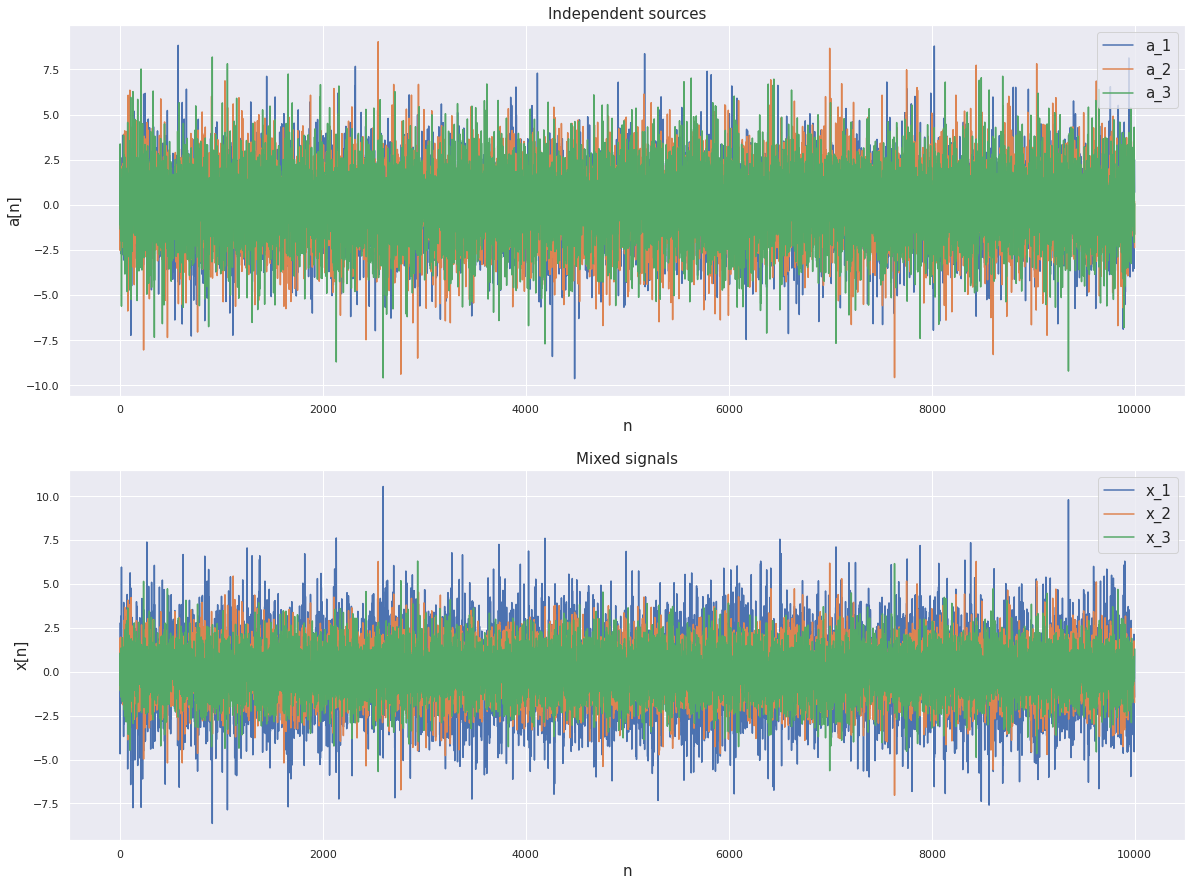

In [2]:
# Signal size
N=10000

# Number of independent sources
K=3

# Generate sources
a = np.random.logistic(
    0,
    1,
    (K, N)
)

# Mixing matrix
H = np.random.uniform(
    -1,
    1,
    size=(K,K)
)

# Get mixed signals
x = H@a

# Plot signals
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(20, 15)
)
for i in range(1,K+1):
    ax1.plot(
        range(N),
        a[i-1,:],
        label='a_{}'.format(i)
    )
    ax2.plot(
        range(N),
        x[i-1,:],
        label='x_{}'.format(i)
    )
    
ax1.set_xlabel('n', fontsize=15)
ax2.set_xlabel('n', fontsize=15)

ax1.set_ylabel('a[n]', fontsize=15)
ax2.set_ylabel('x[n]', fontsize=15)

ax1.set_title('Independent sources', fontsize=15)
ax2.set_title('Mixed signals', fontsize=15)
    
ax1.legend(loc='upper right', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)

# 2. Find optimal W

### 2.1. Random initialization

In [3]:
# Initialize random W
W=np.random.uniform(
    -1,
    1,
    size=(K,K)
)

# Iterate to find optimal W
n_it=500
learning_rate=0.01
logs = pd.DataFrame()
combinations = [t for t in itertools.combinations(
    range(1,K+1),
    2
)]
for k in range(1, n_it+1):
    y=W@x
    delta_W=np.zeros((K,K))
    for t in range(N):
        delta_W = delta_W - (2/N)*np.tanh(y[:,t]).reshape((K,1))@x[:,t].reshape((1,K))
    
    # import pdb;pdb.set_trace()
    delta_W = np.linalg.inv(W.T) + delta_W

    # Update unmixing matrix
    W = W + learning_rate*delta_W
    
    # Update logs matrix
    logs_update = pd.DataFrame(
        index=[0],
        data={
            'it': [k],
            'gradient_magnitude': np.sum(np.abs(delta_W))
        }
    )
    for c in combinations:
        logs_update['mutual_info_{}{}'.format(c[0], c[1])] = MI(
            y.T, y.T[:,c[1]-1]
        )[c[0]-1]
    
    logs = pd.concat(
        [
            logs,
            logs_update
        ],
        axis=0
    )

Text(0.5, 0, 'iteration')

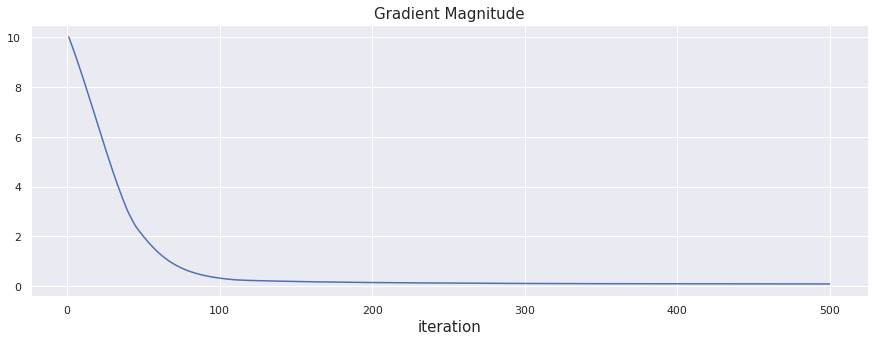

In [4]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.gradient_magnitude
)
plt.title('Gradient Magnitude', fontsize=15)
plt.xlabel('iteration', fontsize=15)

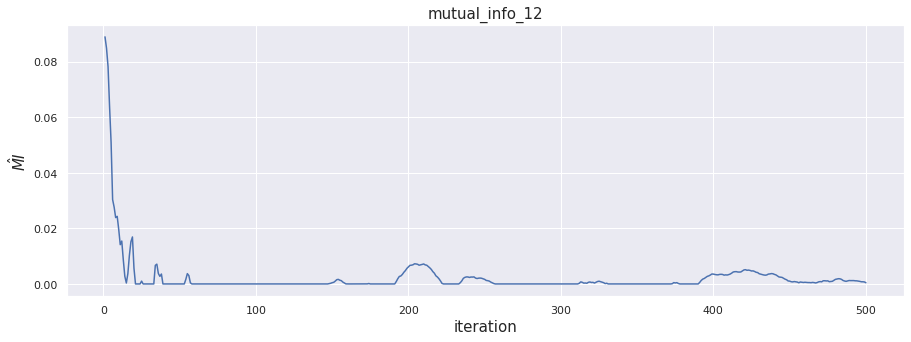

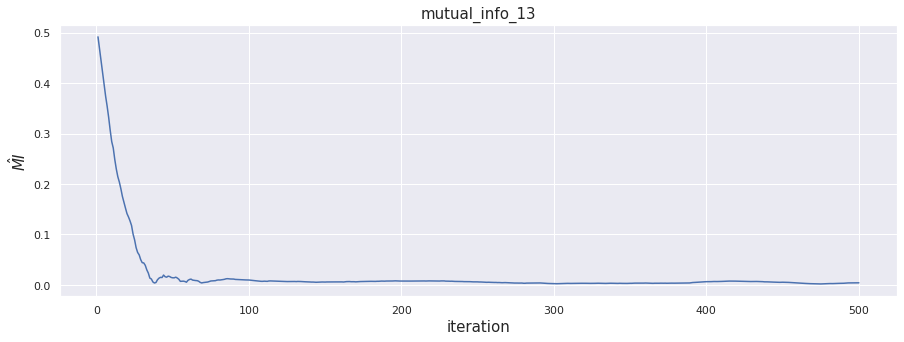

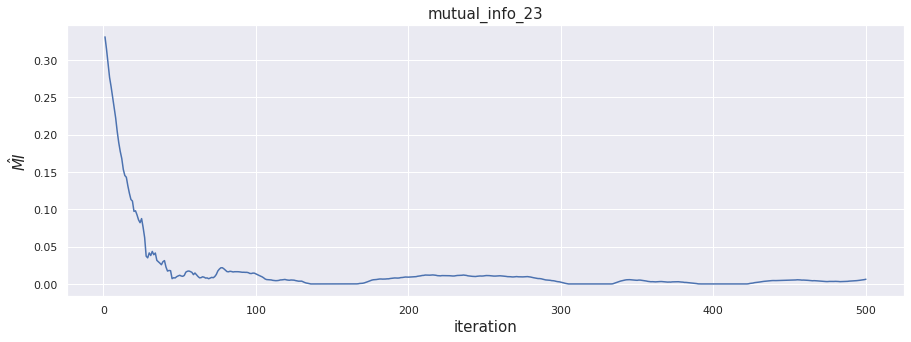

In [5]:
# Plot mutual info
for c in [col for col in logs.columns if 'mutual_info' in col]:
    fig = plt.figure(figsize=((15,5)))
    plt.plot(
        logs.it,
        logs[c]
    )
    plt.title(c, fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

In [6]:
W, np.linalg.inv(H)

(array([[ 0.10801237,  0.4435288 , -0.2288713 ],
        [-0.28619431,  0.9952342 ,  0.91556698],
        [ 0.36006927,  0.20882541,  0.64946842]]),
 array([[ 0.22799251, -2.16430391, -2.13739751],
        [ 0.22818131,  0.54938485, -0.82980473],
        [-0.90828642,  0.37945383, -0.4472566 ]]))

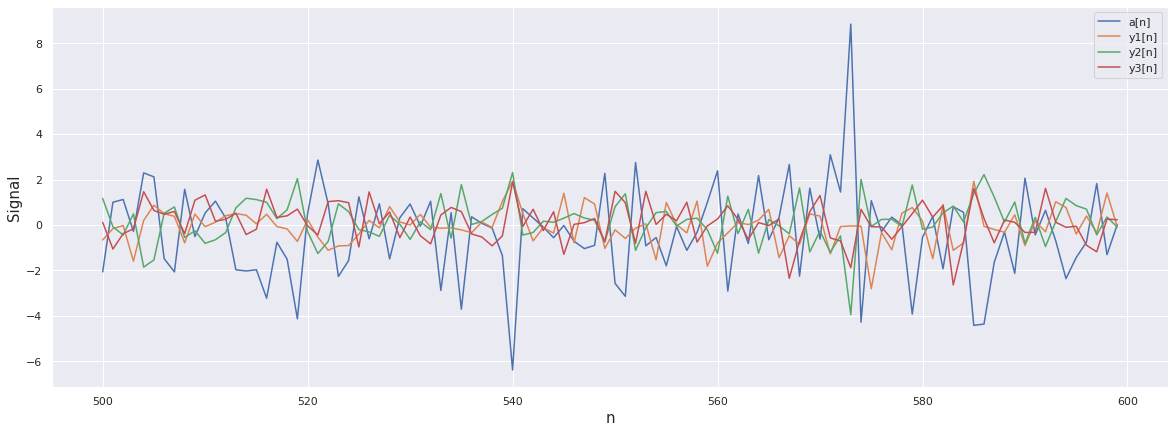

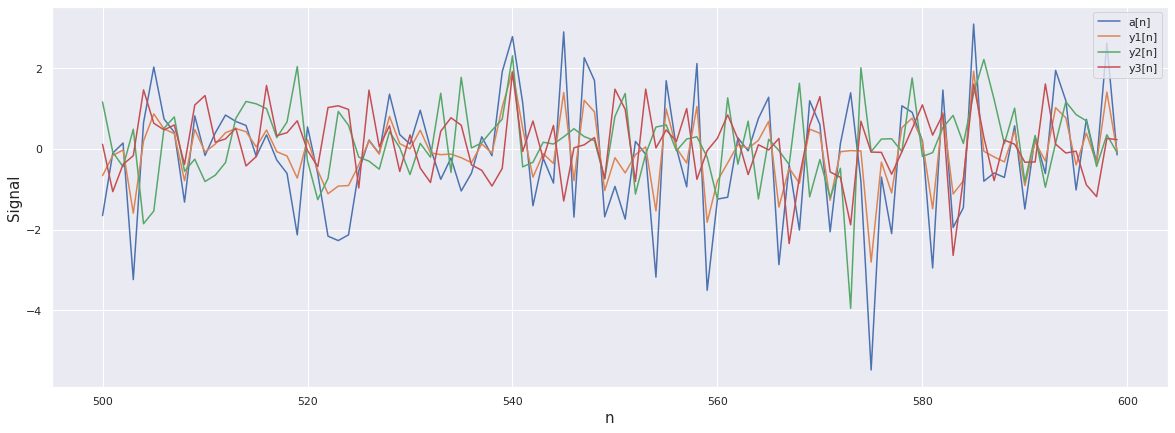

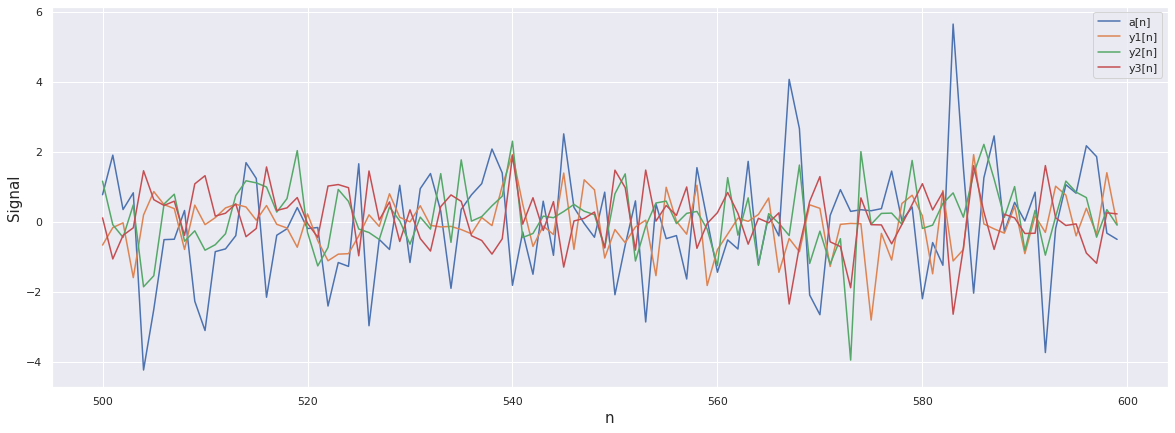

In [7]:
start_idx=500
end_idx=600

for i in range(1,K+1):
    fig = plt.figure(figsize=(20,7))
    # Plot original source
    plt.plot(
        range(start_idx, end_idx),
        a[i-1,start_idx:end_idx],
        label='a[n]'
    )
    # Plot estimations
    plt.plot(
        range(start_idx, end_idx),
        y[0,start_idx:end_idx],
        label='y1[n]'
    )
    plt.plot(
        range(start_idx, end_idx),
        y[1,start_idx:end_idx],
        label='y2[n]'
    )
    plt.plot(
        range(start_idx, end_idx),
        y[2,start_idx:end_idx],
        label='y3[n]'
    )
    plt.xlabel(
        'n',
        fontsize=15
    )
    plt.ylabel(
        'Signal',
        fontsize=15
    )
    plt.legend(
        loc='upper right'
    )

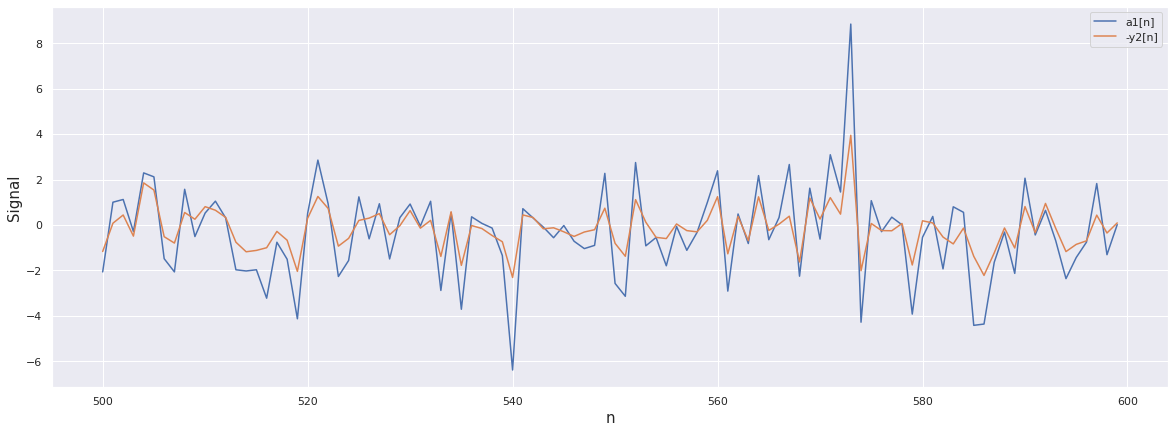

In [11]:
fig = plt.figure(figsize=(20,7))
# Plot original source
plt.plot(
    range(start_idx, end_idx),
    a[0,start_idx:end_idx],
    label='a1[n]'
)
# Plot estimations
plt.plot(
    range(start_idx, end_idx),
    -1*y[1,start_idx:end_idx],
    label='-y2[n]'
)
plt.xlabel(
    'n',
    fontsize=15
)
plt.ylabel(
    'Signal',
    fontsize=15
)
plt.legend(
    loc='upper right'
)

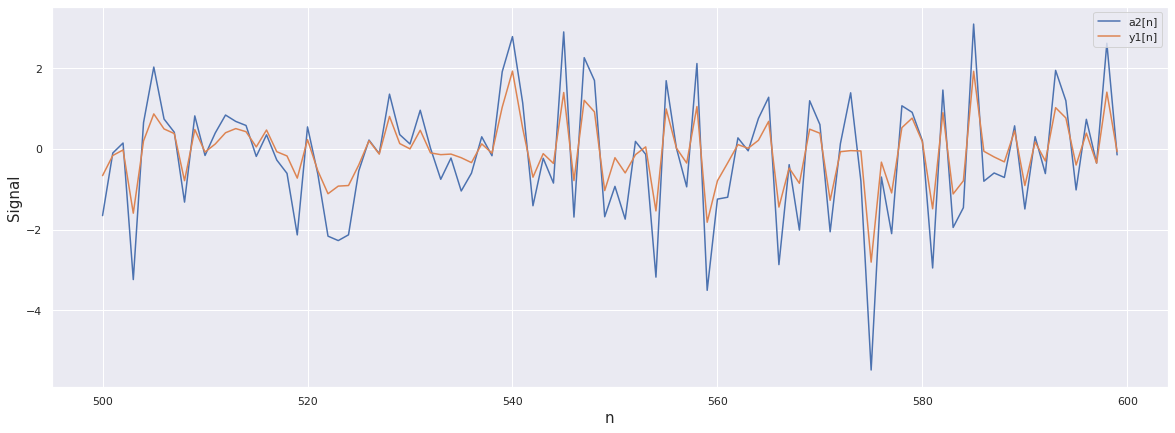

In [12]:
fig = plt.figure(figsize=(20,7))
# Plot original source
plt.plot(
    range(start_idx, end_idx),
    a[1,start_idx:end_idx],
    label='a2[n]'
)
# Plot estimations
plt.plot(
    range(start_idx, end_idx),
    y[0,start_idx:end_idx],
    label='y1[n]'
)
plt.xlabel(
    'n',
    fontsize=15
)
plt.ylabel(
    'Signal',
    fontsize=15
)
plt.legend(
    loc='upper right'
)

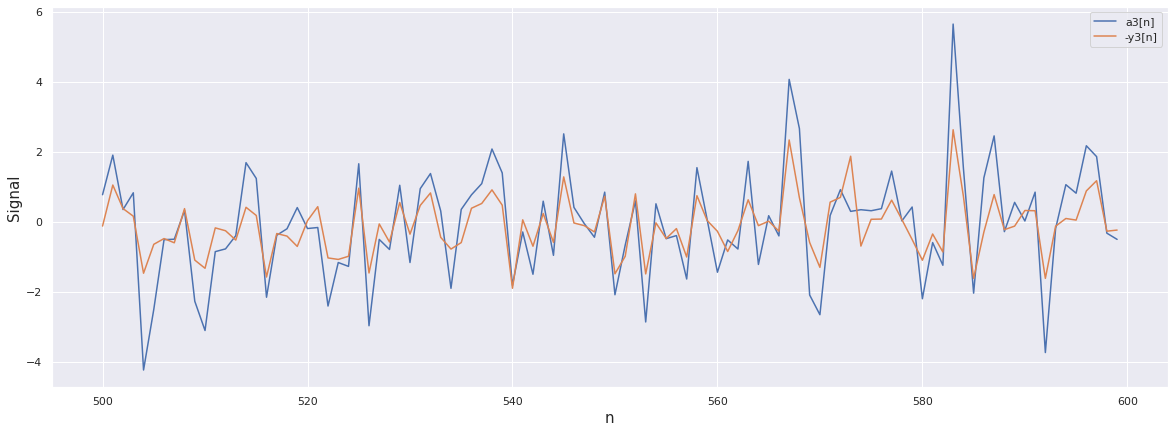

In [13]:
fig = plt.figure(figsize=(20,7))
# Plot original source
plt.plot(
    range(start_idx, end_idx),
    a[2,start_idx:end_idx],
    label='a3[n]'
)
# Plot estimations
plt.plot(
    range(start_idx, end_idx),
    -y[2,start_idx:end_idx],
    label='-y3[n]'
)
plt.xlabel(
    'n',
    fontsize=15
)
plt.ylabel(
    'Signal',
    fontsize=15
)
plt.legend(
    loc='upper right'
)

### 2.2. PCA Initialization

In [13]:
# Get eigenvalues and eigenvectors for correlation matrix of x
eigvals, eigvecs = np.linalg.eigh(
    a=pd.DataFrame(x.T).corr()
)

# Get corresponding transformation matrix
W = np.diag([
    np.sqrt(lamb) for lamb in eigvals
])@eigvecs

# Iterate to find optimal W
n_it=1000
learning_rate=0.01
logs = pd.DataFrame()
combinations = [t for t in itertools.combinations(
    range(1,K+1),
    2
)]
for k in range(1, n_it+1):
    y=W@x
    delta_W=np.zeros((K,K))
    for t in range(N):
        delta_W = delta_W - (2/N)*np.tanh(y[:,t]).reshape((K,1))@x[:,t].reshape((1,K))
    
    # import pdb;pdb.set_trace()
    delta_W = np.linalg.inv(W.T) + delta_W

    # Update unmixing matrix
    W = W + learning_rate*delta_W
    
    # Update logs matrix
    logs_update = pd.DataFrame(
        index=[0],
        data={
            'it': [k],
            'gradient_magnitude': np.sum(np.abs(delta_W))
        }
    )
    for c in combinations:
        logs_update['mutual_info_{}{}'.format(c[0], c[1])] = MI(
            y.T, y.T[:,c[1]-1]
        )[c[0]-1]
    
    logs = pd.concat(
        [
            logs,
            logs_update
        ],
        axis=0
    )

Text(0.5, 0, 'iteration')

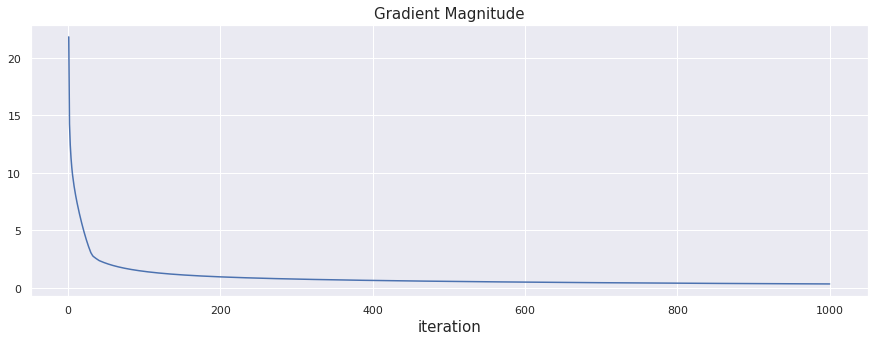

In [14]:
# Plot gradient magnitude
fig = plt.figure(figsize=((15,5)))
plt.plot(
    logs.it,
    logs.gradient_magnitude
)
plt.title('Gradient Magnitude', fontsize=15)
plt.xlabel('iteration', fontsize=15)

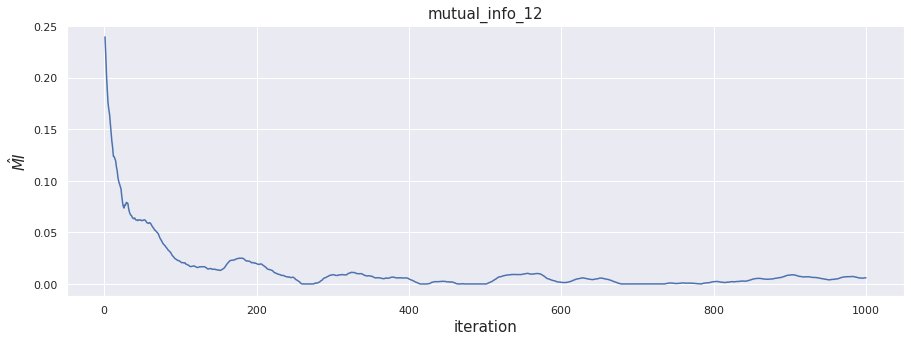

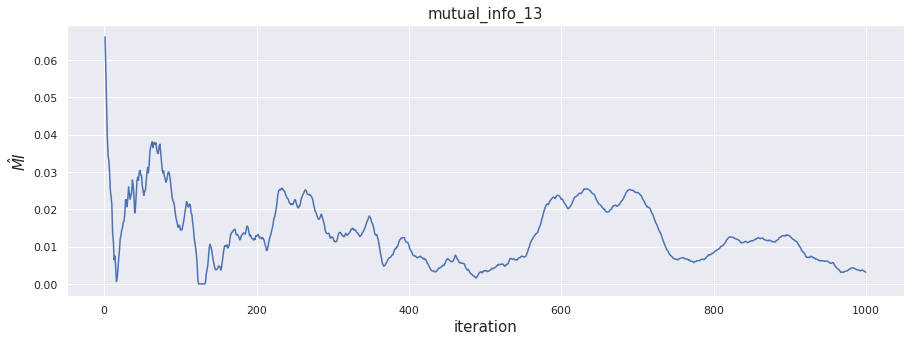

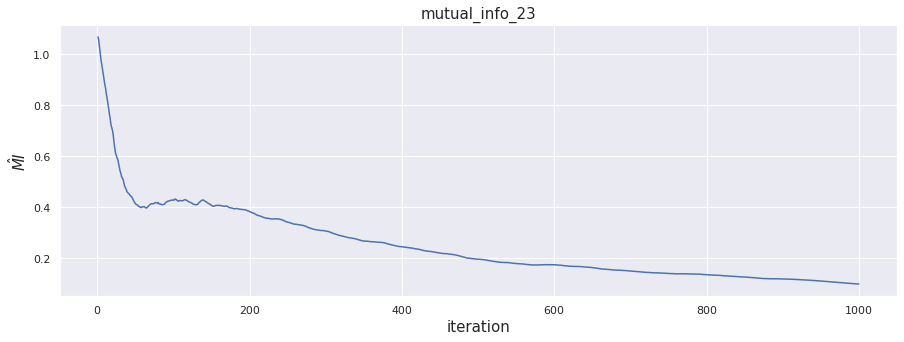

In [15]:
# Plot mutual info
for c in [col for col in logs.columns if 'mutual_info' in col]:
    fig = plt.figure(figsize=((15,5)))
    plt.plot(
        logs.it,
        logs[c]
    )
    plt.title(c, fontsize=15)
    plt.xlabel('iteration', fontsize=15)
    plt.ylabel('$\hat{MI}$', fontsize=15)

In [16]:
W, np.linalg.inv(H)

(array([[ 0.25792283, -0.87166941,  0.05545279],
        [-0.8659114 ,  1.72257391, -1.63603   ],
        [-0.24624029,  2.04637049, -2.41071395]]),
 array([[-2.7438438 ,  8.34851657, -8.53324963],
        [-0.47070872,  1.80776848, -0.22103084],
        [-0.0090315 ,  3.58557947, -4.45528762]]))

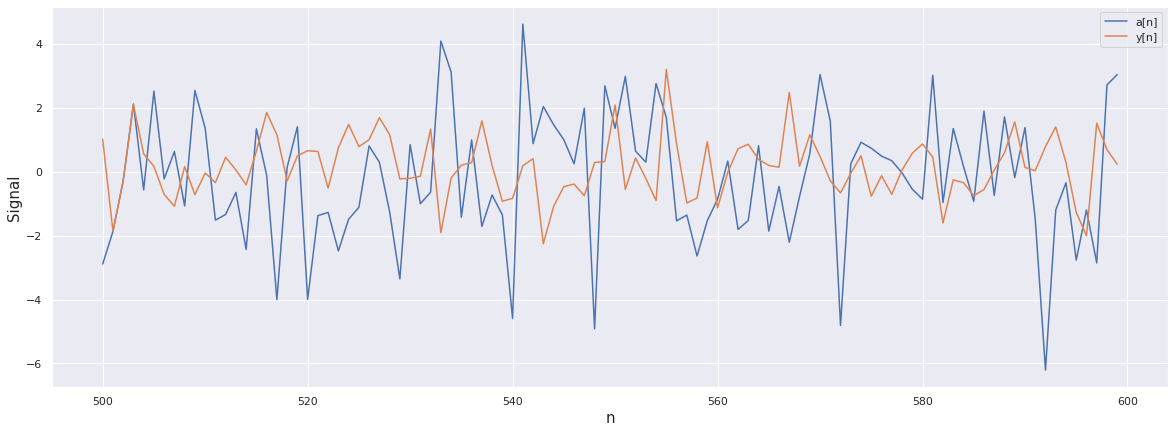

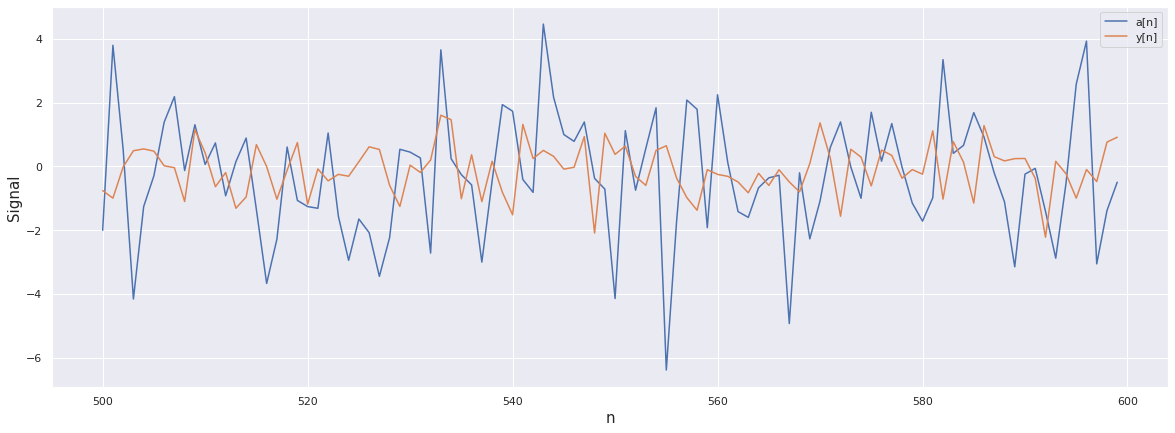

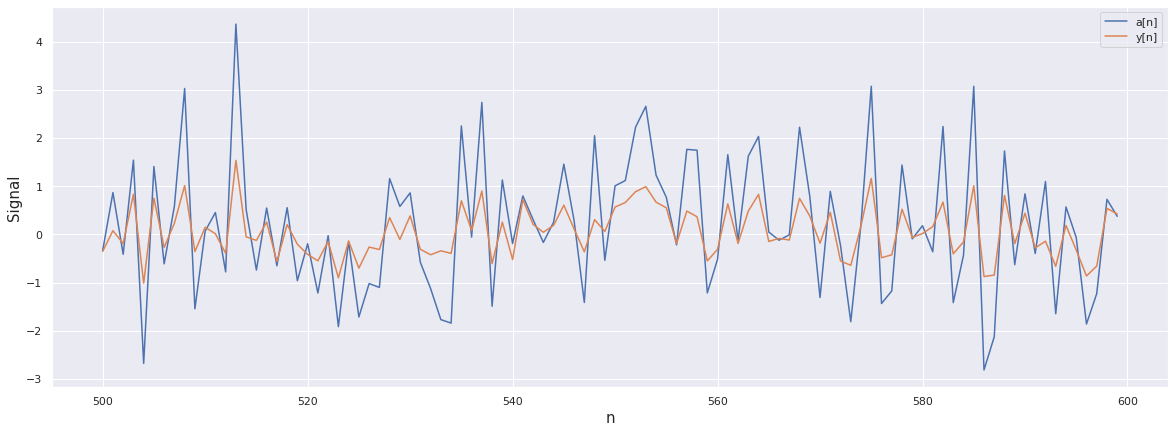

In [17]:
start_idx=500
end_idx=600

for i in range(1,K+1):
    fig = plt.figure(figsize=(20,7))
    plt.plot(
        range(start_idx, end_idx),
        a[i-1,start_idx:end_idx],
        label='a[n]'
    )
    plt.plot(
        range(start_idx, end_idx),
        y[i-1,start_idx:end_idx],
        label='y[n]'
    )
    plt.xlabel(
        'n',
        fontsize=15
    )
    plt.ylabel(
        'Signal',
        fontsize=15
    )
    plt.legend(
        loc='upper right'
    )